In [136]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torchmetrics

import numpy as np

from utils import train_model

## Custom Dataset

Our custom dataset generates arithmetic strings like this:  "minus three plus four plus one minus zero" etc.  Each string also gets a label of 1 if the sum is positive, otherwise the label is zero.

In [137]:
class ArithmeticSequenceDataset(Dataset):
    def __init__(self, num_samples, max_length=20, seed=None):
        np.random.seed(seed)
        self.num_samples = num_samples
        self.max_length = max_length
        self.num_map = {
            "zero": 0, "one": 1, "two": 2, "three": 3, "four": 4,
            "five": 5, "six": 6, "seven": 7, "eight": 8, "nine": 9
        }
        self.data, self.labels = self.generate_dataset(num_samples, max_length)

    def generate_dataset(self, num_samples, max_length):
        operators = ["plus", "minus"]
        digits = list(self.num_map.keys())  # Including "zero"
        sequences = []
        labels = []

        for _ in range(num_samples):
            length = np.random.randint(1, max_length + 1)
            numbers = np.random.choice(digits, length, replace=True)
            ops = np.random.choice(operators, length, replace=True)
            sequence = " ".join([f"{op} {num}" for op, num in zip(ops, numbers)])
            # Calculate the sum considering zero does not change the sum
            sum_numbers = np.sum([self.num_map[num] if op == "plus" else -self.num_map[num] for op, num in zip(ops, numbers)])
            #label = int(sum_numbers > 0)
            label = np.float32( sum_numbers > 0 ) # return floats for BCELoss and torchmetrics accuracy
            sequences.append(sequence)
            labels.append(label)
        
        return sequences, labels

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]


In [138]:
train_dataset = ArithmeticSequenceDataset(20000, 10, seed=42)
valid_dataset = ArithmeticSequenceDataset(2000, 10, seed=98)

In [139]:
seq, label = valid_dataset[1]
seq,label

('plus five minus two minus nine minus three plus seven plus four plus six plus four plus nine plus two',
 1.0)

## Classify using Class Token

A common approach to classification problems with transformers is to add a token at the beginning of the sequence called a class token, or '<CLS>'.  The transformer model encodes the sequence including the class token and the class token is passed to the classifier layer.  The model learns to aggregate information about the sequence into the class token through the learning process.

Here's how we can include the class token in the vocabulary and add it the beginning of each sequence through the dataloader.

In [167]:
vocab_cls = {
    "<PAD>": 0, "<CLS>": 1, "plus": 2, "minus": 3,
    "zero": 4, "one": 5, "two": 6, "three": 7, "four": 8,
    "five": 9, "six": 10, "seven": 11, "eight": 12, "nine": 13
}

def pad_batch_cls(batch):
    sequences, labels = zip(*batch)
    max_length = max(len(seq.split()) for seq in sequences)
    padded_sequences = []
    for seq in sequences:
        tokens = ['<CLS>'] + seq.split()
        padded = [vocab_cls[token] for token in tokens] + [vocab_cls["<PAD>"]] * (max_length + 1 - len(tokens))
        padded_sequences.append(padded)
    return torch.tensor(padded_sequences), torch.tensor(labels)


In [168]:
tokens = ['<CLS>'] + seq.split()
max_length = 20
padded = [vocab_cls[token] for token in tokens] + [vocab_cls["<PAD>"]] * (max_length + 1 - len(tokens))
print(seq)
print(tokens)
print(padded)

plus five minus two minus nine minus three plus seven plus four plus six plus four plus nine plus two
['<CLS>', 'plus', 'five', 'minus', 'two', 'minus', 'nine', 'minus', 'three', 'plus', 'seven', 'plus', 'four', 'plus', 'six', 'plus', 'four', 'plus', 'nine', 'plus', 'two']
[1, 2, 9, 3, 6, 3, 13, 3, 7, 2, 11, 2, 8, 2, 10, 2, 8, 2, 13, 2, 6]


## A Simple Transformer - One Head and One Layer - Step By Step

To integrate the `SingleHeadAttention` class into the Transformer model while explicitly showing the computations and the modular approach, we'll adjust the class definition slightly to correctly handle the scaling factor and ensure proper device placement for tensors like the scaling factor. Additionally, I'll include it in the Transformer block setup as requested.

### Step 1: Define the Single Head Attention Module

Here's the `SingleHeadAttention` class with a small adjustment to ensure the scaling factor works correctly with various devices (e.g., when using GPUs).

In [142]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SingleHeadAttention(nn.Module):
    def __init__(self, embed_dim):
        super(SingleHeadAttention, self).__init__()
        self.query = nn.Linear(embed_dim, embed_dim)
        self.key = nn.Linear(embed_dim, embed_dim)
        self.value = nn.Linear(embed_dim, embed_dim)
        self.scale = torch.sqrt(torch.FloatTensor([embed_dim]))

    def forward(self, x):
        Q = self.query(x)
        K = self.key(x)
        V = self.value(x)
        attention_scores = torch.matmul(Q, K.transpose(-2, -1)) / self.scale
        self.attention = F.softmax(attention_scores, dim=-1)
        return torch.matmul(self.attention, V)

### Step 2: Define the Transformer Block Including SingleHeadAttention

Now we integrate `SingleHeadAttention` within a Transformer block, which includes layer normalization and an MLP.

In [143]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, hidden_dim):
        super(TransformerBlock, self).__init__()
        self.attention = SingleHeadAttention(embed_dim)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, embed_dim)
        )
        self.norm2 = nn.LayerNorm(embed_dim)

    def forward(self, x):
        # Attention and first residual connection + layer norm
        attn_output = self.attention(x)
        x = self.norm1(x + attn_output)
        
        # MLP and second residual connection + layer norm
        x2 = self.mlp(x)
        x = self.norm2(x + x2)
        return x

### Step 3: Define the Postional Encoder

In [144]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=500):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return x

### Step 4a: Define the Full Transformer Classifier Model

Now, assemble the full classifier that uses the Transformer block.  We'll look at two variations here.  The models are nearly the same, but in version 4a we'll use 

In [148]:
class SimpleTransformerClassToken(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.pos_encoder = PositionalEncoding(embed_dim)
        self.transformer_block = TransformerBlock(embed_dim, hidden_dim)
        self.classifier = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        x = self.pos_encoder(x)
        x = self.transformer_block(x)
        cls_token = x[:, 0, :]  # Assuming <CLS> token is at the first position
        output = self.classifier(cls_token).squeeze()  # Ensure dimension match for labels
        return output

In [172]:
train_dataset = ArithmeticSequenceDataset(20000, 10, seed=42)
valid_dataset = ArithmeticSequenceDataset(2000, 10, seed=99)

train_loader_cls = DataLoader(train_dataset, batch_size=100, shuffle=True, collate_fn=pad_batch_cls)
valid_loader_cls = DataLoader(valid_dataset, batch_size=100, shuffle=False, collate_fn=pad_batch_cls)

In [173]:
simple_transformer_cls = SimpleTransformerClassToken(vocab_size=14, embed_dim=64, hidden_dim=256, num_classes=1)
loss_function = nn.BCEWithLogitsLoss()
num_epochs=25

metrics = {'accuracy': torchmetrics.Accuracy(task='binary'),}

simple_transformer_token = train_model(simple_transformer_cls, loss_function,
                         epochs = num_epochs,
                         metrics = metrics,
                         train_loader = train_loader_cls,
                         val_loader = valid_loader_cls)

Epoch 25/25, Training 100.00% complete, Validation 100.00% complete lr = 1.000e-03
 Epoch  train_accuracy  train_loss  val_accuracy  val_loss     Time    LR
    21         0.83175    0.330641        0.8460  0.314637 1.838973 0.001
    22         0.83415    0.324287        0.8405  0.310743 1.937561 0.001
    23         0.83210    0.323940        0.8420  0.315021 1.894592 0.001
    24         0.83280    0.324227        0.8440  0.319973 1.894785 0.001
    25         0.83240    0.322532        0.8435  0.313090 1.903668 0.001


`Trainer.fit` stopped: `max_epochs=25` reached.


#### Visualizing the Attention Weights

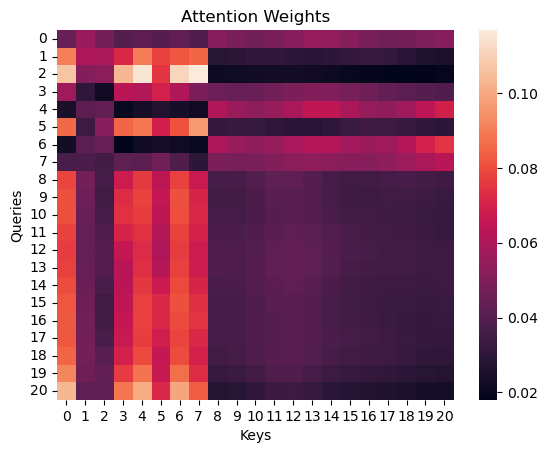

tensor([2, 9, 1, 4, 2, 7, 2, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


In [194]:
import random

simple_transformer.eval()  # Set the model to evaluation mode

# Randomly select a sequence from the validation set
valid_sequences, valid_labels = next(iter(valid_loader))
idx = random.randint(0, valid_sequences.size(0) - 1)
sequence, label = valid_sequences[idx], valid_labels[idx]

# Perform the forward pass
with torch.no_grad():
    predictions = simple_transformer_cls(sequence.unsqueeze(0))  # Add batch dimension if needed

# Retrieve the attention weights from the attention module
attention_weights = simple_transformer_cls.transformer_block.attention.attention

# Assuming sequence_tokens is a list of token strings that corresponds to the indices in sequence
import seaborn as sns
import matplotlib.pyplot as plt

# Visualize the attention weights
sns.heatmap(attention_weights.squeeze(0).cpu().numpy())#, xticklabels=sequence_tokens, yticklabels=sequence_tokens)
plt.xlabel('Keys')
plt.ylabel('Queries')
plt.title('Attention Weights')
plt.show()

print(sequence)

### Use average embedding instead of a class token

We'll take away the class token from the vocabulary and change the model to average over the sequence dimensions to produce a single embedding to pass to the classifier.  Here are the necessary changes in one cell:

In [157]:
vocab = {
    "<PAD>": 0, "plus": 1, "minus": 2,
    "zero": 3, "one": 4, "two": 5, "three": 6, "four": 7,
    "five": 8, "six": 9, "seven": 10, "eight": 11, "nine": 12
}

def pad_batch(batch):
    sequences, labels = zip(*batch)
    max_length = max(len(seq.split()) for seq in sequences)
    padded_sequences = []
    for seq in sequences:
        tokens = seq.split()
        padded = [vocab[token] for token in tokens] + [vocab["<PAD>"]] * (max_length + 1 - len(tokens))
        padded_sequences.append(padded)
    return torch.tensor(padded_sequences), torch.tensor(labels)

train_dataset = ArithmeticSequenceDataset(20000, 10, seed=42)
valid_dataset = ArithmeticSequenceDataset(2000, 10, seed=99)

train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True, collate_fn=pad_batch)
valid_loader = DataLoader(valid_dataset, batch_size=100, shuffle=False, collate_fn=pad_batch)

class SimpleTransformerAverage(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.pos_encoder = PositionalEncoding(embed_dim)
        self.transformer_block = TransformerBlock(embed_dim, hidden_dim)
        self.classifier = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        x = self.pos_encoder(x)
        x = self.transformer_block(x)
        avg_sequence = x.mean(dim=1)
        output = self.classifier(avg_sequence).squeeze()
        return output

In [162]:
simple_transformer_avg = SimpleTransformerAverage(vocab_size=13, embed_dim=64, hidden_dim=256, num_classes=1)
loss_function = nn.BCEWithLogitsLoss()
num_epochs=25

metrics = {'accuracy': torchmetrics.Accuracy(task='binary'),}

simple_transformer_avg_df = train_model(simple_transformer_avg, loss_function,
                         epochs = num_epochs,
                         metrics = metrics,
                         train_loader = train_loader,
                         val_loader = valid_loader)

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 25/25, Training 100.00% complete, Validation 100.00% complete lr = 1.000e-03
 Epoch  train_accuracy  train_loss  val_accuracy  val_loss     Time    LR
    21         0.99375    0.029984        0.9825  0.039739 1.858514 0.001
    22         0.99410    0.028743        0.9875  0.030317 1.866807 0.001
    23         0.99255    0.028747        0.9925  0.029139 1.830252 0.001
    24         0.99345    0.026068        0.9925  0.026984 1.843769 0.001
    25         0.99525    0.023814        0.9920  0.026238 1.825504 0.001


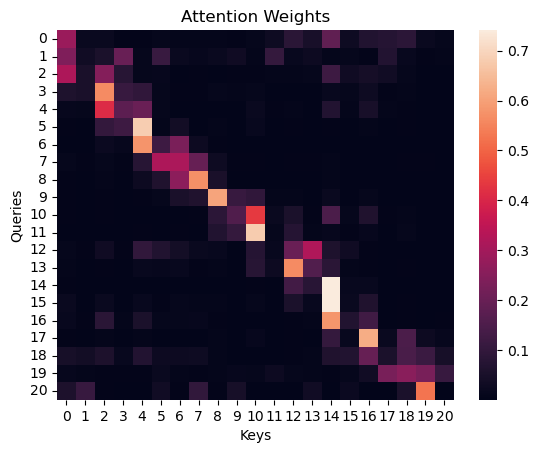

tensor([ 2,  8,  2, 12,  2, 11,  1,  7,  1, 10,  2, 12,  1,  5,  2,  5,  1, 12,
         1,  8,  0])


In [166]:
import random

simple_transformer.eval()  # Set the model to evaluation mode

# Randomly select a sequence from the validation set
valid_sequences, valid_labels = next(iter(valid_loader))
idx = random.randint(0, valid_sequences.size(0) - 1)
sequence, label = valid_sequences[idx], valid_labels[idx]

# Perform the forward pass
with torch.no_grad():
    predictions = simple_transformer_avg(sequence.unsqueeze(0))  # Add batch dimension if needed

# Retrieve the attention weights from the attention module
attention_weights = simple_transformer_avg.transformer_block.attention.attention

# Assuming sequence_tokens is a list of token strings that corresponds to the indices in sequence
import seaborn as sns
import matplotlib.pyplot as plt

# Visualize the attention weights
sns.heatmap(attention_weights.squeeze(0).cpu().numpy())#, xticklabels=sequence_tokens, yticklabels=sequence_tokens)
plt.xlabel('Keys')
plt.ylabel('Queries')
plt.title('Attention Weights')
plt.show()

print(sequence)

For this problem the average embedding works much better.  I think the encoder is able to focus on understanding the numerical meaning of tokens and then the averaging actually computes the sum.  Perhaps the class token approach would benefit from more transfomer layers so some layers could focus on learning the numerical values of the tokens while other layers could do the summation.  We'll use PyTorch's built in TransformerEncoder layer to construct out model.

## Class Token Approach with Multiple Layers

In [175]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=500):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return x

class TransformerClassifierClassTkn(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_heads, num_layers, dropout=0.1):
        super(TransformerClassifierClassTkn, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.pos_encoder = PositionalEncoding(embed_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, 
                                                   dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.classifier = nn.Linear(embed_dim, 1)

    def forward(self, x):
        # Generate the mask from the input indices, where pad tokens are zero
        pad_token_index = 0
        mask = (x != pad_token_index)  # Create a mask with True where tokens are not pad tokens

        x = self.embedding(x)
        x = self.pos_encoder(x)
        
        x = self.transformer_encoder(x, src_key_padding_mask=~mask)  # Use the mask here
        cls_token = x[:, 0, :]  # Assuming <CLS> token is at the first position
        output = self.classifier(cls_token).squeeze()  # Ensure dimension match for labels
        return output


In [180]:
model_class_token = TransformerClassifierClassTkn(vocab_size=14, embed_dim=64, num_heads=1, num_layers=2)
loss_function = nn.BCEWithLogitsLoss()
num_epochs=50

metrics = {'accuracy': torchmetrics.Accuracy(task='binary'),}

transformer_class_tkn_results = train_model(model_class_token, loss_function,
                         epochs = num_epochs,
                         metrics = metrics,
                         train_loader = train_loader_cls,
                         val_loader = valid_loader_cls)

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 50/50, Training 100.00% complete, Validation 100.00% complete lr = 1.000e-03
 Epoch  train_accuracy  train_loss  val_accuracy  val_loss      Time    LR
    46         0.94600    0.127242        0.9890  0.050166 16.507487 0.001
    47         0.94465    0.126841        0.9655  0.074767 16.458869 0.001
    48         0.94490    0.122813        0.9755  0.073665 16.465624 0.001
    49         0.94595    0.121032        0.9835  0.053385 16.461081 0.001
    50         0.94800    0.121401        0.9705  0.072783 16.359883 0.001


## Classify by Averaging Output Sequence

In [7]:
vocab = {
    "<PAD>": 0, "plus": 1, "minus": 2,
    "zero": 3, "one": 4, "two": 5, "three": 6, "four": 7,
    "five": 8, "six": 0, "seven": 10, "eight": 11, "nine": 12
}

def pad_batch(batch):
    sequences, labels = zip(*batch)
    max_length = max(len(seq.split()) for seq in sequences)
    padded_sequences = []
    for seq in sequences:
        tokens = seq.split()
        padded = [vocab[token] for token in tokens] + [vocab["<PAD>"]] * (max_length + 1 - len(tokens))
        padded_sequences.append(padded)
    return torch.tensor(padded_sequences), torch.tensor(labels)


In [28]:
import torch
import torch.nn as nn

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=500):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return x

class TransformerClassifierMeanAgg(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_heads, num_layers, dropout=0.1):
        super(TransformerClassifierMeanAgg, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.pos_encoder = PositionalEncoding(embed_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.classifier = nn.Linear(embed_dim, 1)  # Output one logit

    def forward(self, x):
        pad_token_index = 0
        mask = (x != pad_token_index)  # Mask for padding tokens
        
        x = self.embedding(x)
        x = self.pos_encoder(x)

        # Compute the attention mask for transformer (invert mask for attention mechanism)
        attention_mask = ~mask  # Mask needs to be the same size as the sequence length

        x = self.transformer_encoder(x, src_key_padding_mask=attention_mask)
        
        # Compute the average across all non-padding tokens

        mask_expanded = mask.unsqueeze(-1).expand_as(x)  # Expand the mask to cover embedding dimensions
        x_masked = x * mask_expanded.float()  # Apply mask to zero-out pad tokens in output
        seq_lengths = mask.sum(dim=1, keepdim=True)  # Count non-padding elements for each batch element
        avg_pool = x_masked.sum(dim=1) / seq_lengths  # Compute average only over non-padded elements

        output = self.classifier(avg_pool).squeeze()  # Pass the average through the classifier
        return output


In [29]:
train_dataset = ArithmeticSequenceDataset(20000, 10, seed=42)
valid_dataset = ArithmeticSequenceDataset(2000, 10, seed=99)

train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True, collate_fn=pad_batch)
valid_loader = DataLoader(valid_dataset, batch_size=100, shuffle=False, collate_fn=pad_batch)

In [30]:
model_mean_agg = TransformerClassifierMeanAgg(vocab_size=14, embed_dim=64, num_heads=1, num_layers=1, use_mask=False)
loss_function = nn.BCEWithLogitsLoss()
num_epochs=10

metrics = {'accuracy': torchmetrics.Accuracy(task='binary'),}

transformer_mean_agg_results = train_model(model_mean_agg, loss_function,
                         epochs = num_epochs,
                         metrics = metrics,
                         train_loader = train_loader,
                         val_loader = valid_loader)

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10/10, Training 100.00% complete, Validation 100.00% complete lr = 1.000e-03
 Epoch  train_accuracy  train_loss  val_accuracy  val_loss     Time    LR
     6         0.86920    0.289466        0.8845  0.256895 8.047414 0.001
     7         0.88795    0.257764        0.9095  0.208965 8.046697 0.001
     8         0.90180    0.229500        0.9230  0.193499 8.078786 0.001
     9         0.91390    0.205224        0.9265  0.168538 8.154873 0.001
    10         0.92435    0.178121        0.9455  0.133000 8.318631 0.001
